In [910]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

**Car** 

In [911]:
def create_car(car_id, position, velocity):
    return {
        "id": car_id,
        "position": position,
        "velocity": velocity,
        "history_time": [],
        "history_vel": [],
        "history_pos": []
    }

def log_car_state(car, time):
    car["history_time"].append(time)
    car["history_vel"].append(car["velocity"])
    car["history_pos"].append(car["position"])

def generate_car(total_car, velocity):
    cars = []
    for i in range(total_car, 0, -1):
        pos = i * 15
        car = create_car(total_car - i, pos, velocity)
        cars.append(car)
    return cars

# How We Simulate Traffic and Why Jams Happen

## 1. Predicting the Future: Solving ODEs with Simple Physics

**The Core Breakthrough:** Our traffic simulation works by repeatedly applying fundamental physics equations that actually solve Ordinary Differential Equations (ODEs)!

### The Physics Foundation
Every moving car follows Newton's basic motion laws:
$$ \frac{dx}{dt} = v \quad \text{(Position changes at rate = velocity)} $$
$$ \frac{dv}{dt} = a \quad \text{(Velocity changes at rate = acceleration)} $$

### How We Solve These ODEs in Code
In simulation loop, these simple physics updates:
```python
# Update Velocity: v = v + at  (Euler step for dv/dt = a)
cur_car["velocity"] += safe_acc * h

# Update Position: x = x + vt  (Euler step for dx/dt = v) 
cur_car["position"] += cur_car["velocity"] * h
```

**Are actually Euler's Method solving the ODEs!** Each time step `h` moves the system forward by approximating:
- New velocity = old velocity + (acceleration × time step)
- New position = old position + (velocity × time step)

**Key Insight:** By repeating these simple formulas thousands of times with tiny time steps, we predict how traffic flows evolve over time—turning mathematical ODEs into realistic traffic behavior.

## 2. The Driver's Brain (IDM Model)
We give every simulated car a "brain" called the 

**Intelligent Driver Model (IDM)**. It calculates the acceleration ($a$) using this formula:

$$ a = a_{max} \left[ 1 - \left( \frac{v}{v_0} \right)^\delta - \left( \frac{s^*}{s} \right)^2 \right] $$

### What do the symbols mean?
*   **$a$ (Acceleration):** How much the driver presses the gas pedal (positive) or brake pedal (negative).
*   **$a_{max}$ (Max Acceleration):** The maximum power of the car's engine.
*   **$v$ (Current Speed):** How fast the car is going right now.
*   **$v_0$ (Desired Speed):** The speed limit or how fast the driver *wants* to go.
*   **$\delta$ (Delta):** How aggressively the driver accelerates when the road is open.

*   **$s$ (Actual Gap):** The real distance to the car in front.**Conclusion:** If drivers are calm and keep a safe distance, traffic flows smoothly. If they are aggressive, phantom jams appear.

*   **$s^*$ (Desired Gap):** The safe distance the driver *wants* to keep. If the real gap ($s$) is smaller than this ($s^*$), the driver brakes.

*   **Result:** This "wave" of braking travels backward, eventually causing cars miles behind to come to a complete stop.

## 3. Why Phantom Jams Happen*   

**The Chain Reaction:** If one aggressive driver taps the brakes, the car behind them panics and brakes harder. The next car brakes even harder.

A "phantom jam" is when traffic stops for no apparent reason (no accidents or roadworks).*   **Aggressive Behavior:** Driving fast, braking hard, and following too closely.

In our model, this happens **only when drivers are aggressive**.

In [912]:
# Adjusted IDM parameters for more aggressive stopping behavior
T = 2.0          # time gap 
A_MAX = 0.5      # how hard he press the gas
B_COMF = 3.0     # how hard he brake
DELTA = 6        # higher = more sensitive
S0 = 2.0        # minimum gap before collision
MAX_BRAKING = -8.0 # Strong braking capability

# find the best acceleration via model 
def get_idm_acceleration(current_car, front_car, desired_velocity, road_length):
    cur_vel = current_car["velocity"]
    front_vel = front_car["velocity"]
    
    gap_vel = cur_vel - front_vel
    gap_pos = front_car["position"] - current_car["position"]


    if gap_pos < 0:
        gap_pos += road_length
    
    # IDM desired spacing: s* = s₀ + vT + (vΔv)/(2√ab)
    s_star = S0 + max(0, cur_vel * T + (cur_vel * gap_vel) / (2 * np.sqrt(A_MAX * B_COMF)))
    
    safe_gap = max(gap_pos - 5.0, 0.1)
    
    velocity_term = (cur_vel / desired_velocity) ** DELTA  
    gap_term = (s_star / safe_gap) ** 2                   

    # IDM acceleration formula: a = a_max[1 - (v/v₀)^δ - (s*/s)²]
    acc = A_MAX * (1 - velocity_term - gap_term)
    
    if gap_pos < 8.0:  
        acc = min(acc, -2.0)
    
    if gap_pos < 3.0:
        acc = MAX_BRAKING   
    
    acc = max(min(acc, A_MAX), MAX_BRAKING)
    return acc

Key concept is to get calculate for acceleration and then predict the next velocity and position for each car repeatly

In [913]:
def run_simulate(total_car, max_velocity, time_bound, h):
    # generate car
    cars = generate_car(total_car, max_velocity)    
    # road_length = total_car * 16.67
    road_length = 300

    steps = int(time_bound / h)
    current_time = 0.0

    for _ in range(steps):    
        for i in range(len(cars)):
            front_car = cars[i]
            cur_car = cars[(i + 1)% total_car]

            if (9 < current_time < 10 and cur_car["id"] == 0):
                cur_car["velocity"] -= 0.9 * h
                if cur_car["velocity"] < 0:
                    cur_car["velocity"] = 0
                cur_car["position"] += cur_car["velocity"] * h
                log_car_state(cur_car, current_time)
                continue
            
            log_car_state(cur_car, current_time)
            # Get safe acceleration
            safe_acc = get_idm_acceleration(cur_car, front_car, max_velocity, road_length)

            # Update Velocity: v = v + at
            cur_car["velocity"] += safe_acc * h
            if cur_car["velocity"] > max_velocity:
                cur_car["velocity"] = max_velocity
            if cur_car["velocity"] < 0: 
                cur_car["velocity"] = 0 

            # Update Position: x = x + vt
            cur_car["position"] += cur_car["velocity"] * h
            
            if cur_car["position"] >= road_length:
                cur_car["position"] -= road_length
        
        current_time += h

    return cars, road_length

cars, road_length = run_simulate(18, 9, 200, 0.1)

In [914]:
from IPython.display import Image

def animate_traffic_from_start(cars, road_length, filename="phantom_traffic.gif"):
    start_x = []
    start_y = []
    car_colors = []
    
    track_radius = 1.0
    
    import matplotlib.cm as cm
    colors = cm.Set3(np.linspace(0, 1, len(cars)))

    for i, car in enumerate(cars):
        pos_0 = car["history_pos"][0]
    
        theta = (pos_0 / road_length) * (2 * np.pi)
        x = track_radius * np.cos(theta)
        y = track_radius * np.sin(theta)
        
        start_x.append(x)
        start_y.append(y)
        # Emphasize the lead car visually
        if i == 0:
            car_colors.append('red')
        else:
            car_colors.append(colors[i])
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title("Phantom Traffic Jam (Circular)", fontsize=15)
    
    ax.add_artist(plt.Circle((0, 0), track_radius, color='#eeeeee', fill=False, linewidth=20))

    scatter_dots = ax.scatter(start_x, start_y, s=150, c=car_colors, 
                              edgecolors='black', zorder=10)
    
    # Text cues
    time_text = ax.text(0, 0, '0.0 s', ha='center', va='center', fontsize=14, fontweight='bold')
    lead_text = ax.text(0, -1.1, '', ha='center', va='center', fontsize=12, color='red')

    def update_frame(frame_index):
        x_coords = []
        y_coords = []
        current_time = 0.0

        for car in cars:
            if frame_index < len(car["history_pos"]):
                pos = car["history_pos"][frame_index]
                
                if car["id"] == 0: 
                    current_time = car["history_time"][frame_index]
            else:
                pos = car["history_pos"][-1]
                if car["id"] == 0:
                    current_time = car["history_time"][-1]

            theta = (pos / road_length) * (2 * np.pi)
            x = track_radius * np.cos(theta)
            y = track_radius * np.sin(theta)
            
            x_coords.append(x)
            y_coords.append(y)
            
        scatter_dots.set_offsets(np.c_[x_coords, y_coords])
        time_text.set_text(f'{current_time:.1f} s')

        sizes = np.full(len(cars), 150.0)
        if 0 < current_time - 10 < 0.1 and car["id"] == 0:
            sizes[0] = 260.0 
            lead_text.set_text('Lead car slows down')
        else:
            lead_text.set_text('')
        scatter_dots.set_sizes(sizes)
        
        return [scatter_dots, time_text, lead_text]

    total_frames = len(cars[0]["history_pos"])
    skip = 5  # Skip more frames for faster playback
    
    ani = FuncAnimation(fig, update_frame, frames=range(0, total_frames, skip), 
                        interval=40, blit=False, repeat=True)  # Faster interval

    ani.save(filename, writer='pillow', fps=25, dpi=80)  # Higher FPS
    plt.close(fig)
    print(f"GIF saved as {filename}")
    
    return filename

def generate_gif(cars, road_length, filename="traffic_simulation.gif"):
    return animate_traffic_from_start(cars, road_length, filename=filename)

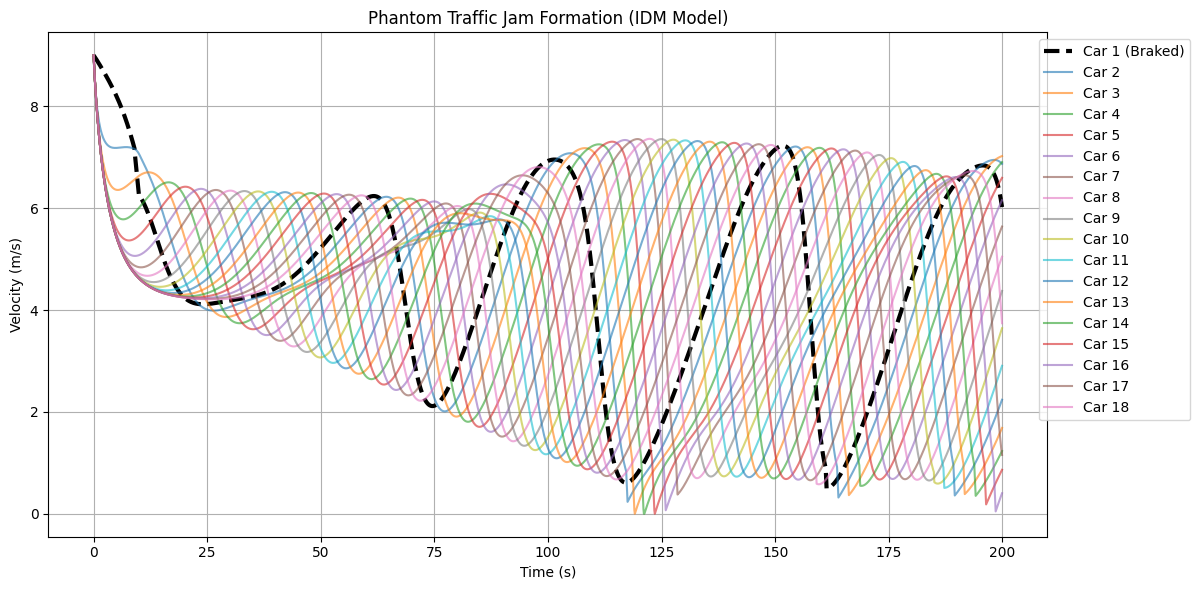

In [915]:
plt.figure(figsize=(12, 6))
for car in cars:
    if car["id"] == 0:
        plt.plot(car["history_time"], car["history_vel"], label=f'Car {car["id"]+1} (Braked)', linewidth=3, color='black', linestyle='--')
    else:
        plt.plot(car["history_time"], car["history_vel"], label=f'Car {car["id"]+1}', alpha=0.6)
    
plt.title("Phantom Traffic Jam Formation (IDM Model)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

GIF saved as traffic_simulation.gif


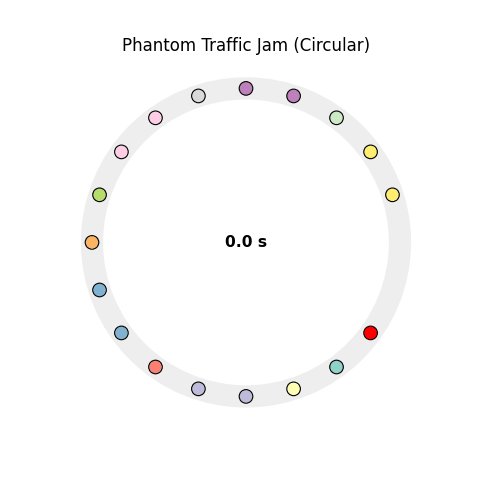

In [916]:
# Save GIF and display as static image (auto-loops in Jupyter)
gif_path = generate_gif(cars, road_length)
Image(filename=gif_path)